## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

## Import Dataset

In [4]:
import zipfile

z = zipfile.ZipFile('dataset.zip')

z.extractall()

# 1) Data Preparation

In [6]:
folder = 'dataset/yes/'
count= 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files have been renamed in the yes dir.")

All files have been renamed in the yes dir.


In [7]:
folder = 'dataset/no/'
count= 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files have been renamed in the no dir.")

All files have been renamed in the no dir.


# 2) Exploratory Data Analysis

In [8]:
listyes = os.listdir("dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


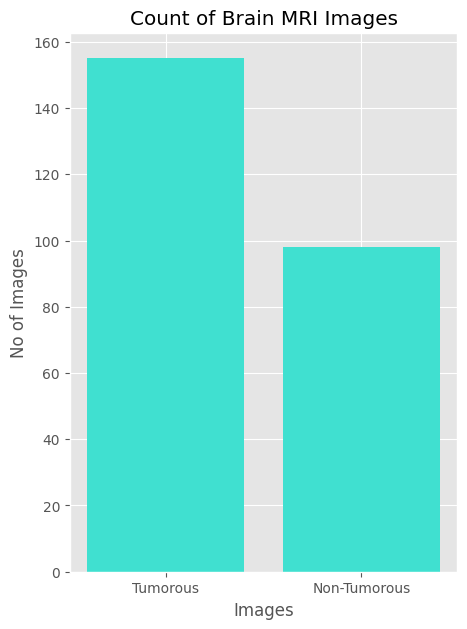

In [13]:
data = {'Tumorous': number_files_yes, 'Non-Tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="turquoise")

plt.xlabel("Images")
plt.ylabel("No of Images")
plt.title("Count of Brain MRI Images")
plt.show()

# 3) Data Augmentation

## Import Libraries

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [15]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [16]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [20]:
import time
start_time = time.time()

yes_path = 'dataset/yes'
no_path = 'dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:57.87851810455322


In [23]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of samples: {n}")
    print(f"Number of positive samples: {n_pos}")
    print(f"Number of negative samples: {n_neg}")
    print(f"Number of positive samples in percentage: {pos_per} %")
    print(f"Number of negative samples in percentage: {neg_per} %")

In [24]:
data_summary(augmented_data_path)

Number of samples: 2065
Number of positive samples: 1085
Number of negative samples: 980
Number of positive samples in percentage: 52.54237288135593 %
Number of negative samples in percentage: 47.45762711864407 %


In [25]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1085
980


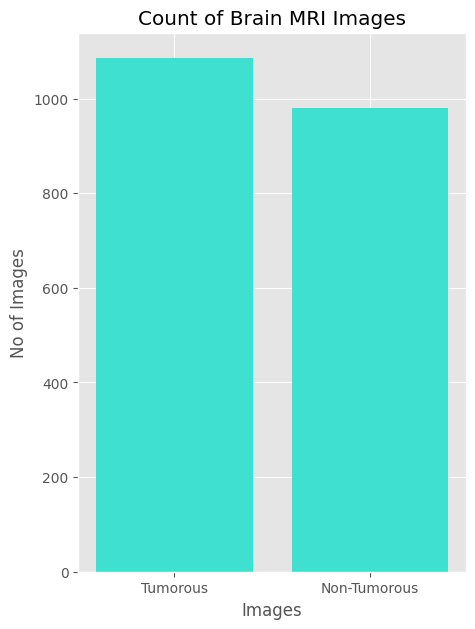

In [26]:
data = {'Tumorous': number_files_yes, 'Non-Tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="turquoise")

plt.xlabel("Images")
plt.ylabel("No of Images")
plt.title("Count of Brain MRI Images")
plt.show()

# 4) Data Preprocessing

In [27]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

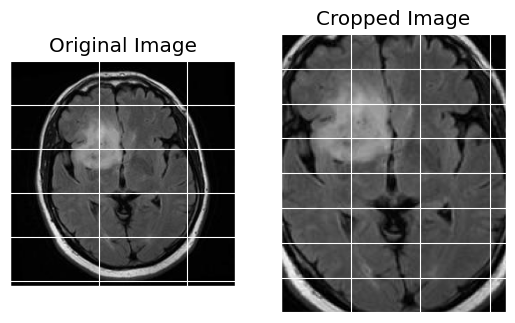

array([[[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [1, 1, 1],
        [1, 1, 1]],

       [[5, 5, 5],
        [4, 4, 4],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       ...,

       [[4, 4, 4],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[4, 4, 4],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[4, 4, 4],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)
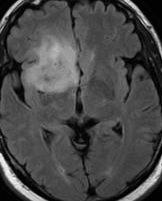

In [32]:
img = cv2.imread('augmented_data/yes/aug_Y_100_0_2735.jpg')
crop_brain_tumor(img, True)

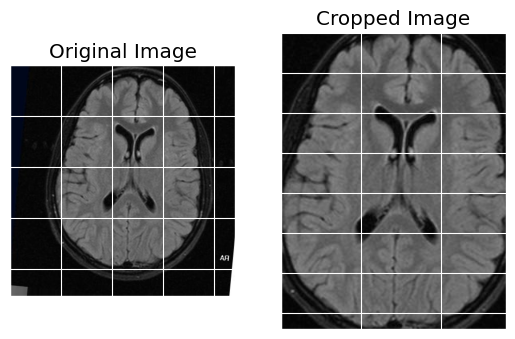

array([[[8, 8, 8],
        [7, 7, 7],
        [6, 6, 6],
        ...,
        [7, 7, 7],
        [7, 7, 7],
        [7, 7, 7]],

       [[7, 7, 7],
        [7, 7, 7],
        [6, 6, 6],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [7, 7, 7]],

       [[7, 7, 7],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [7, 7, 7]],

       ...,

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [5, 5, 5],
        [6, 6, 6],
        [7, 7, 7]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [5, 5, 5],
        [6, 6, 6],
        [7, 7, 7]],

       [[7, 7, 7],
        [7, 7, 7],
        [7, 7, 7],
        ...,
        [6, 6, 6],
        [7, 7, 7],
        [7, 7, 7]]], dtype=uint8)
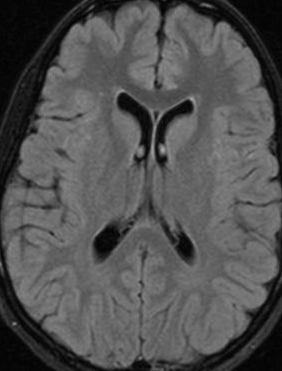

In [33]:
img = cv2.imread('augmented_data/no/aug_N_10_0_2667.jpg')
crop_brain_tumor(img, True)

In [ ]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

## Image Loading

In [34]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of examples are : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [36]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2065
X SHAPE is : (2065, 240, 240, 3)
y SHAPE is : (2065,)


In [37]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

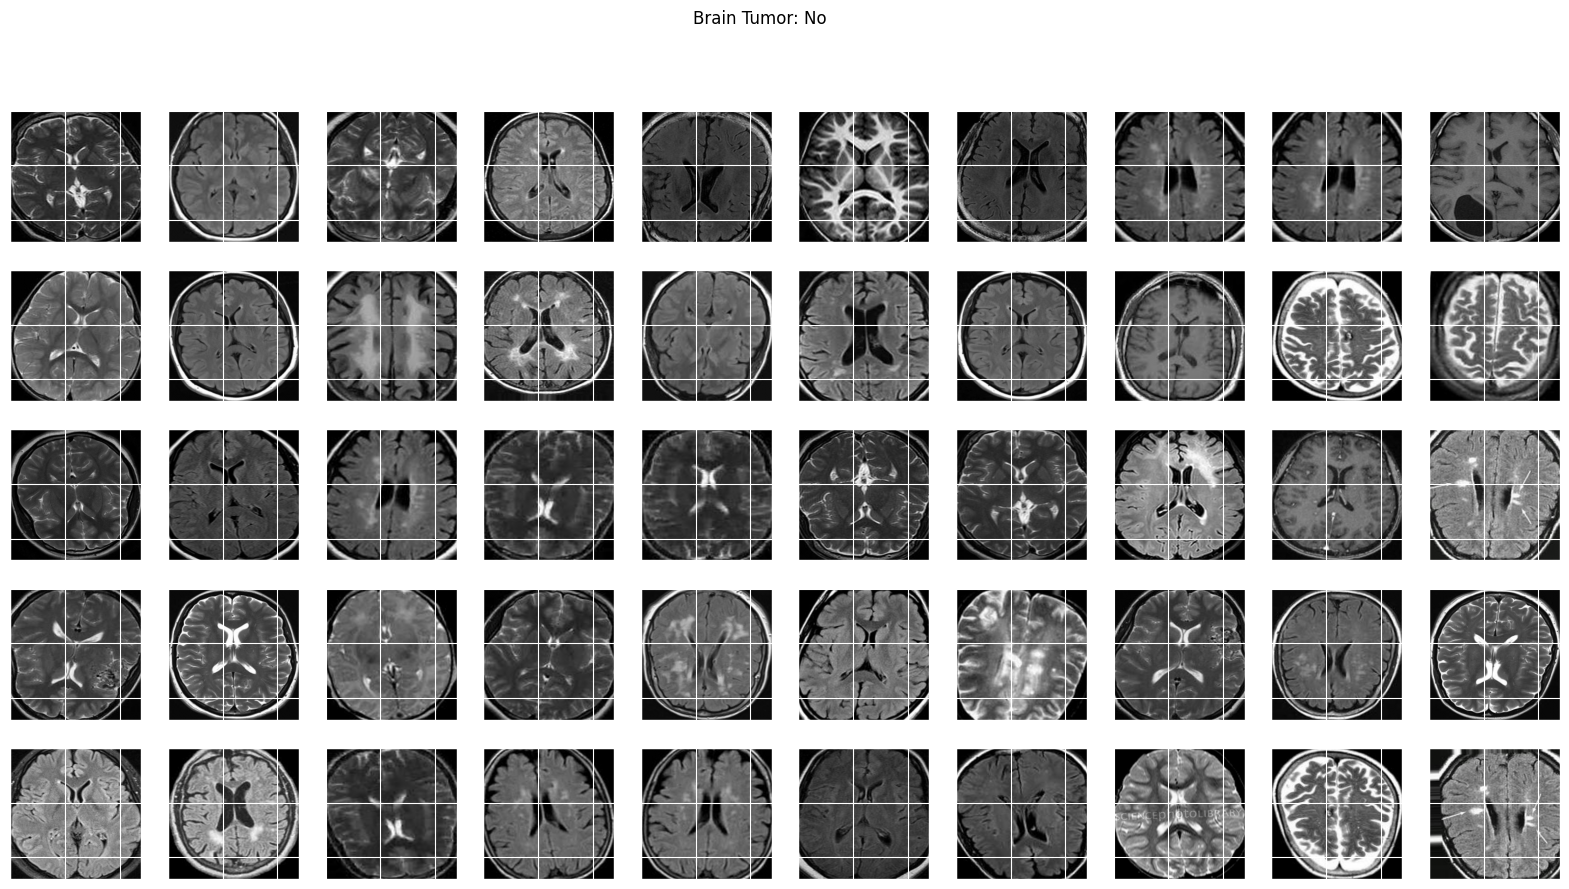

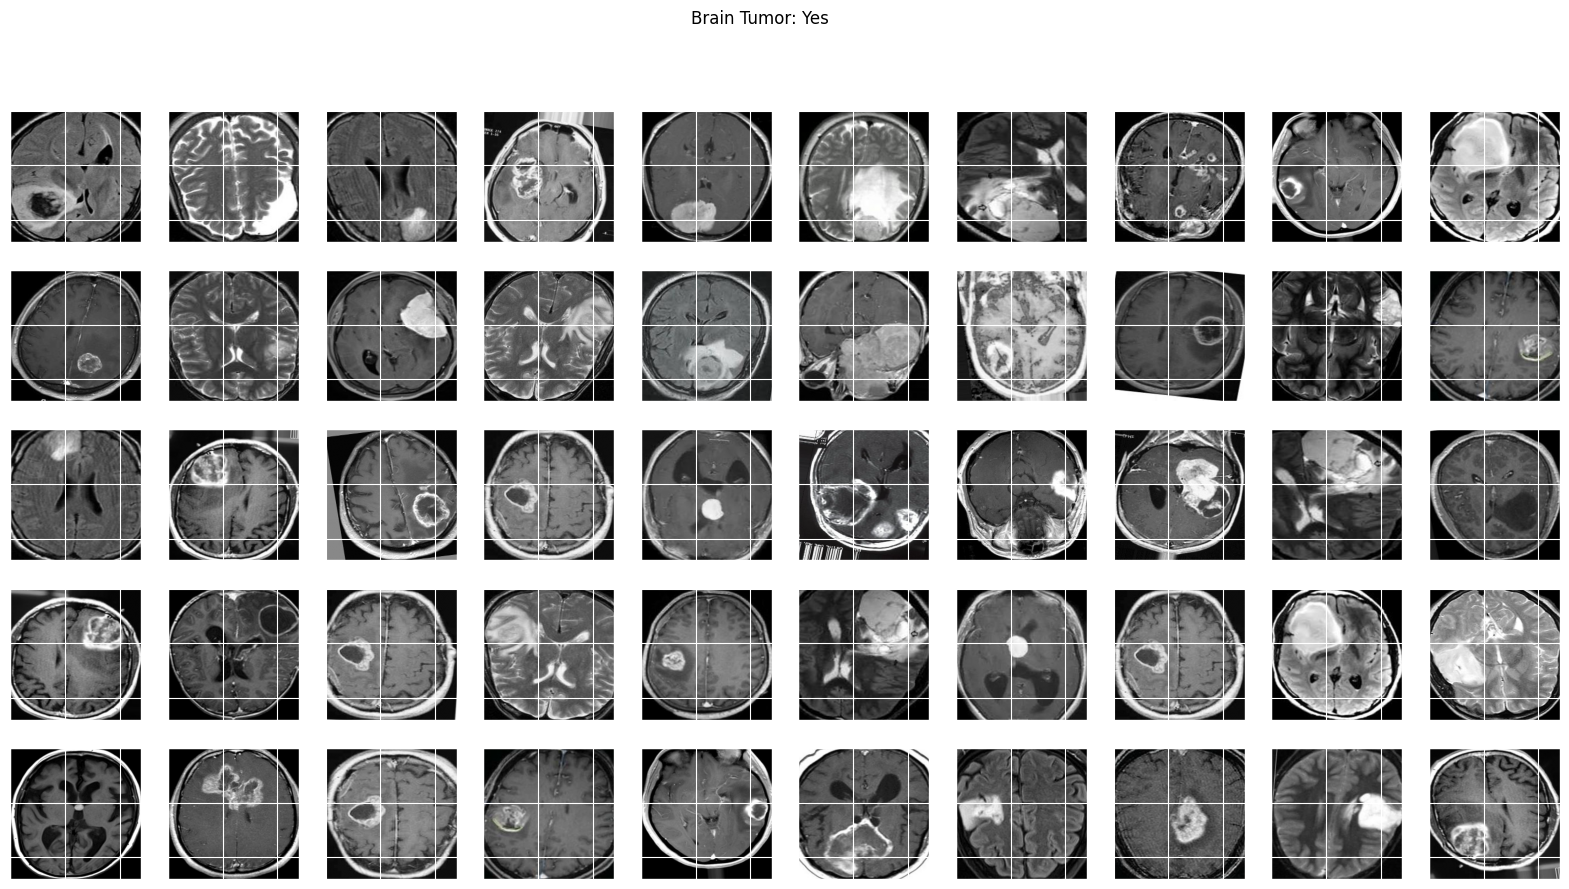

In [38]:
plot_sample_images(X,y)